# Comparing fluxes with other products




In [1]:
import xarray as xr
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import odc.geo
import numpy as np
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_prediction_data import allNaN_arg

import matplotlib 
matplotlib.rcParams.update({'font.size': 16})

## Analysis Parameters

In [2]:
var = 'NEE'
var_fc = 'nee'
results_name = 'NEE_2003_2021_5km_LGBM.nc'

### Open datasets

In [3]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
ds.attrs['nodata'] = np.nan

In [4]:
ds_fc = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs_meteo_era5.nc').sel(time=slice('2003', '2018')), crs='epsg:4326')
ds_fc = ds_fc.rename({'lat':'latitude', 'lon':'longitude'})
ds_fc.attrs['nodata'] = np.nan
ds_fc['latitude'] = ds_fc.latitude.astype('float32')
ds_fc['longitude'] = ds_fc.longitude.astype('float32')

In [5]:
modis_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/MODIS_GPP_1km_monthly_2002_2021.nc')
modis_gpp.attrs['nodata'] = np.nan

In [6]:
gosif_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')
gosif_gpp.attrs['nodata'] = np.nan

In [7]:
evi=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/EVI_5km_monthly_2002_2021.nc')

In [8]:
grid = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/epsg3577_50km_grid.nc')

### Reproject datasets to match EPSG:3577 50km grid

In [9]:
ds = xr_reproject(ds, geobox=grid.geobox, resampling='average')

mask = np.isnan(ds.isel(time=1))

/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [10]:
ds_fc = xr_reproject(ds_fc, geobox=grid.geobox, resampling='bilinear')
ds_fc = ds_fc[var].where(~mask.astype(bool))
ds_fc = ds_fc*30 #/day to /month

In [11]:
modis_gpp = xr_reproject(modis_gpp, geobox=grid.geobox, resampling='average')

modis_gpp = modis_gpp.where(~mask.astype(bool))

In [12]:
gosif_gpp = xr_reproject(gosif_gpp, geobox=grid.geobox, resampling='average')

gosif_gpp = gosif_gpp.where(~mask.astype(bool))

In [13]:
evi=xr_reproject(evi, geobox=grid.geobox, resampling='average')
evi=evi.where(~mask.astype(bool))

## Convert to total C in (petagrams) rather than gC/m2

Find area of pixels

In [14]:
area_per_pixel = ds.geobox.resolution[1]**2

ds = ds * area_per_pixel * 1e-15
ds_fc = ds_fc * area_per_pixel * 1e-15

In [15]:
modis_gpp = modis_gpp * area_per_pixel * 1e-12
gosif_gpp = gosif_gpp * area_per_pixel * 1e-15

## Plot time-series and find annual mean and std dev 

In [ ]:
# annual = ds.resample(time='1Y', label='left', loffset='6M').sum()
# annual_fc = ds_fc.resample(time='1Y', label='left', loffset='6M').sum()

# fig, ax = plt.subplots(1,1, figsize=(15,7))
# ax.plot(annual_fc.time.values, annual_fc.sum(['x','y']), linestyle='--', label='Fluxcom '+var, alpha=0.75)
# # ax.plot(modis_gpp_1D.time.values, modis_gpp_1D, linestyle='--', label='MODIS '+var, alpha=0.75)
# # ax.plot(gosif_gpp_1D.time.values, gosif_gpp_1D, linestyle='--', label='GOSIF '+var, alpha=0.75)
# ax.plot(annual.time.values, annual.sum(['x','y']),  label='This study '+var)
# ax.legend(loc='upper left')
# ax.set_ylabel('Carbon Flux PgC/year');


## Convert to anomalies

### Climatology

In [16]:
import warnings
warnings.filterwarnings("ignore")

ds_clim_mean = ds.groupby('time.month').mean()
ds_clim_mean_annual = ds.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

ds_fc_clim_mean = ds_fc.groupby('time.month').mean()
ds_fc_clim_mean_annual = ds_fc.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

In [17]:
modis_gpp_clim_mean = modis_gpp.groupby('time.month').mean()
modis_gpp_clim_mean_annual = modis_gpp.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

gosif_gpp_clim_mean = gosif_gpp.groupby('time.month').mean()
gosif_gpp_clim_mean_annual = gosif_gpp.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

### Anomalies

In [18]:
ds_anom = (ds.groupby('time.month') - ds_clim_mean)
ds_fc_anom = (ds_fc.groupby('time.month') - ds_fc_clim_mean)

ds_anom_annual = ds.resample(time='1Y', label='left', loffset='6M').sum() - ds_clim_mean_annual
ds_fc_anom_annual = ds_fc.resample(time='1Y', label='left', loffset='6M').sum() - ds_fc_clim_mean_annual

In [19]:
modis_gpp_anom = (modis_gpp.groupby('time.month') - modis_gpp_clim_mean)
gosif_gpp_anom = (gosif_gpp.groupby('time.month') - gosif_gpp_clim_mean)

modis_gpp_anom_annual = modis_gpp.resample(time='1Y', label='left', loffset='6M').sum() - modis_gpp_clim_mean_annual
gosif_gpp_anom_annual = gosif_gpp.resample(time='1Y', label='left', loffset='6M').sum() - gosif_gpp_clim_mean_annual

## Zonal summaries

### Monthly

In [20]:
ds_1D = ds_anom.sum(['x','y'])
ds_fc_1D = ds_fc_anom.sum(['x','y'])

In [21]:
modis_gpp_1D = modis_gpp_anom.sum(['x','y'])
gosif_gpp_1D = gosif_gpp_anom.sum(['x','y'])

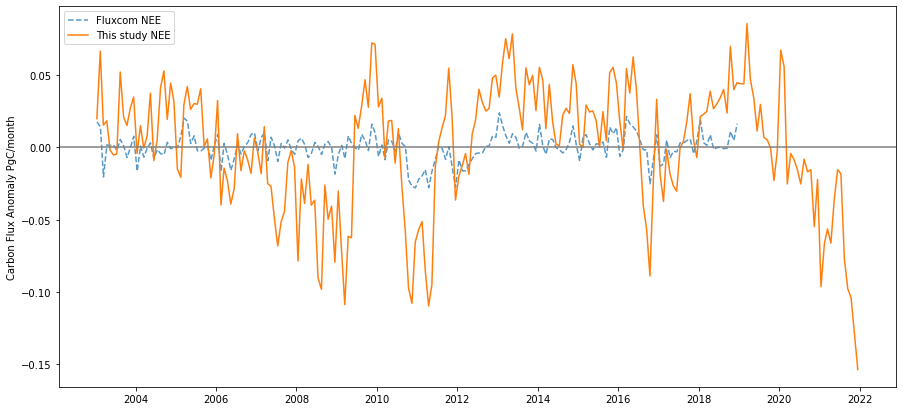

In [22]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_fc_1D.time.values, ds_fc_1D, linestyle='--', label='Fluxcom '+var, alpha=0.75)
# ax.plot(modis_gpp_1D.time.values, modis_gpp_1D, linestyle='--', label='MODIS '+var, alpha=0.75)
# ax.plot(gosif_gpp_1D.time.values, gosif_gpp_1D, linestyle='--', label='GOSIF '+var, alpha=0.75)
ax.plot(ds_1D.time.values, ds_1D,  label='This study '+var)
ax.legend(loc='upper left')
ax.set_ylabel('Carbon Flux Anomaly PgC/month');
# ax.set_ylim(-0.175, 0.175)

# ax2=ax.twinx()
# # ax2.plot(evi_1D.time.values, evi_1D, label='MODIS-EVI', color='c', )
# ax2.legend(loc='upper right')
# ax2.set_ylim(-0.05, 0.05)
# ax2.set_ylabel('EVI Anomaly');

plt.axhline(0, c='grey');
# plt.title(var);



### Annual

In [23]:
ds_1D_annual = ds_anom_annual.sum(['x','y'])
ds_fc_1D_annual = ds_fc_anom_annual.sum(['x','y'])

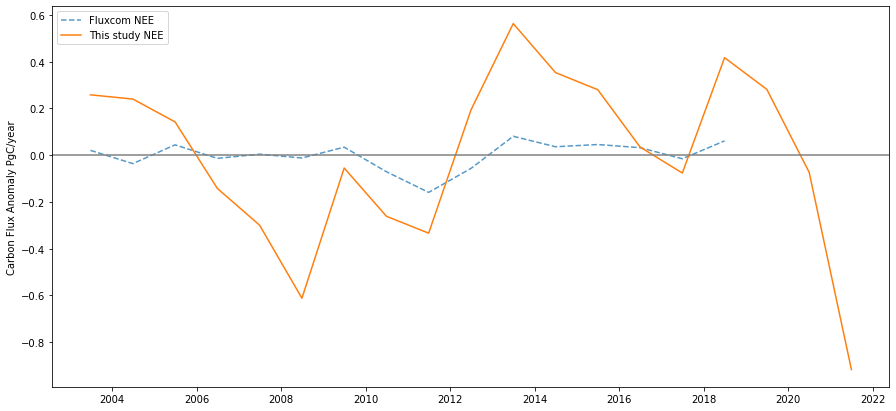

In [24]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_fc_1D_annual.time.values, ds_fc_1D_annual, linestyle='--', label='Fluxcom ' +var, alpha=0.75)
# ax.plot(modis_gpp_annual.time.values, modis_gpp_annual,linestyle='--', label='MODIS '+var, alpha=0.75)
# ax.plot(gosif_gpp_annual.time.values, gosif_gpp_annual, linestyle='--', label='GOSIF '+var, alpha=0.75)
ax.plot(ds_1D_annual.time.values, ds_1D_annual, label='This study '+var)
# ax.set_ylim(-1.1, 1.1)
ax.legend(loc='upper left')
ax.set_ylabel('Carbon Flux Anomaly PgC/year')
plt.axhline(0, c='grey');

# ax2=ax.twinx()
# ax2.plot(evi_annual.time.values, evi_annual, marker='o', linestyle='--', label='MODIS-EVI', color='c')
# ax2.legend(loc='upper left')
# ax2.set_ylabel('EVI Anomaly');

## Month of maximum flux

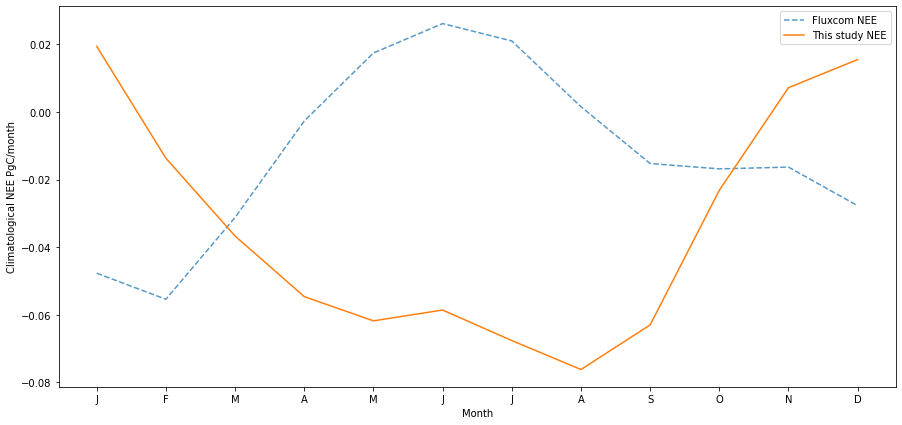

In [25]:
y = ds_clim_mean.where(~mask).sum(['x','y']).values
x = ds_clim_mean.month.values

y_fc = ds_fc_clim_mean.where(~mask).sum(['x','y']).values
x_fc = ds_fc_clim_mean.month.values

# y_modis_gpp = modis_gpp_clim_mean.where(~mask).sum(['x','y']).values
# x_modis_gpp = modis_gpp_clim_mean.month.values

# y_gosif_gpp = gosif_gpp_clim_mean.where(~mask).sum(['x','y']).values
# x_gosif_gpp = gosif_gpp_clim_mean.month.values

fig,ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(x_fc, y_fc, linestyle='--', label='Fluxcom '+var, alpha=0.75)
# ax.plot(x_modis_gpp, y_modis_gpp,  linestyle='--', label='MODIS '+var, alpha=0.75)
# ax.plot(x_gosif_gpp, y_gosif_gpp,  linestyle='--', label='GOSIF '+var, alpha=0.75)
ax.plot(x, y, label='This study '+var)

# ax.axhline(0, c='grey')

# ax.fill_between(x_fc, y_fc-std_fc, y_fc+std_fc, alpha=0.5)
# ax.fill_between(x, y-std, y+std, alpha=0.5)

ax.legend(loc='upper right')
# ax.set_title(var+' Climatology')
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])             
ax.set_ylabel('Climatological '+var+' PgC/month');


In [26]:
if var == 'NEE':
    max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'min')
    max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'min')
    # max_mean_month_modis = allNaN_arg(modis_gpp_clim_mean, 'month', 'min')
    # max_mean_month_gosif = allNaN_arg(gosif_gpp_clim_mean, 'month', 'min')
    #max_mean_season = allNaN_arg(monthly_season, 'season', 'min')
else:
    max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'max')
    max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'max')
    max_mean_month_modis = allNaN_arg(modis_gpp_clim_mean, 'month', 'max')
    max_mean_month_gosif = allNaN_arg(gosif_gpp_clim_mean, 'month', 'max')
    #max_mean_season = allNaN_arg(monthly_season, 'season', 'max')

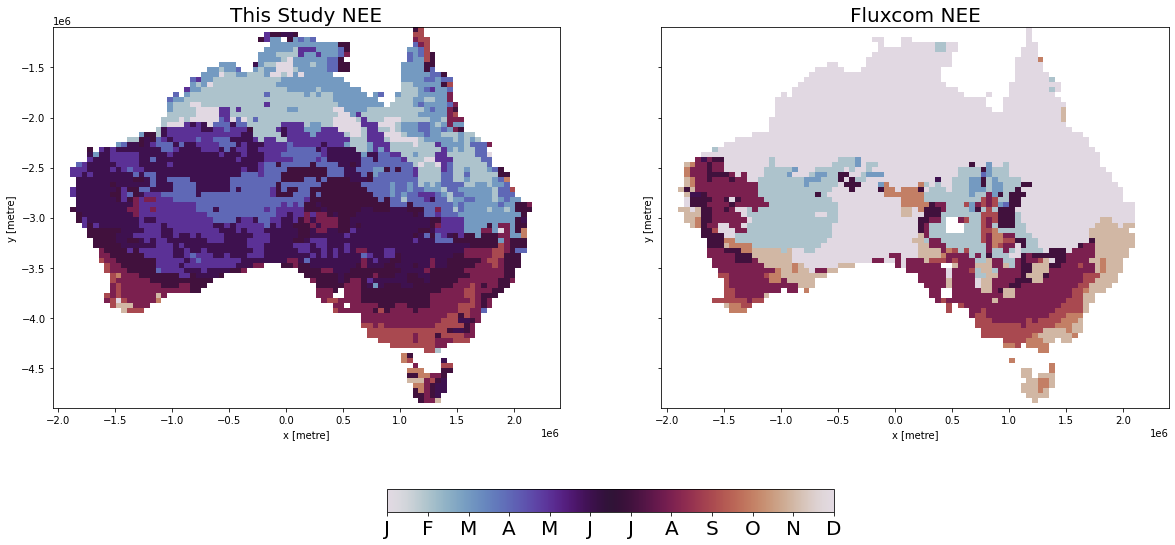

In [27]:
fig,ax = plt.subplots(1,2, figsize=(20,10), sharey=True, sharex=True)

im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0], cmap='twilight', add_colorbar=False)
ax[0].set_title('This Study '+var, fontsize=20);

im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[1], cmap='twilight', add_colorbar=False)
ax[1].set_title('Fluxcom '+var, fontsize=20);

# im = max_mean_month_modis.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False)
# ax[1,0].set_title('MODIS '+var, fontsize=20);

# im = max_mean_month_gosif.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False)
# ax[1,1].set_title('GOSIF '+var, fontsize=20);

cbar = fig.colorbar(im, spacing='uniform', ax=ax.ravel().tolist(), orientation='horizontal', shrink=0.4)
cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=20)

plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/month_of_max_'+var+'.png')
